In [63]:
''' 
Summarizer → 1–2 sentence summary

Sentiment Analyzer → Positive | Neutral | Negative

Merge Node:
Waits for both and returns:

{
  "summary": "...",
  "sentiment": "..."
}


Rules:

Both nodes must run concurrently

No node can read the other’s output

Single fan-out → fan-in graph, no loops
'''

from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv
from typing import TypedDict, Literal

In [64]:
load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation"
)
model = ChatHuggingFace(llm=llm)

In [65]:
class llmstate(TypedDict):
    input: str
    summary: str
    sentiment: Literal["positive", "negative", "neutral"]
    output: str

In [ ]:
def summarize(state: llmstate) -> dict :
    
    summary_answer = model.invoke(f"Give a summary for the following text\n {state['input']}").content.strip()
    
    return {"summary": summary_answer}

def sentiment(state: llmstate) -> dict:
     
     sentiment_answer = model.invoke(f"Check the sentiment of this text and send ONLY one of these words: positive, negative , neutral \n {state['input']}").content.strip()
     
     label = "neutral"
     if "positive" in sentiment_answer:
         label = "positive"
     elif "negative" in sentiment_answer:
         label = "negative"

     
     return {"sentiment": label}

def output(state: llmstate) -> dict:
    answer = {
            
            "Sentiment: ": state["sentiment"],
            "Summary: ": state["summary"]
    }
    
    return {"output": answer}

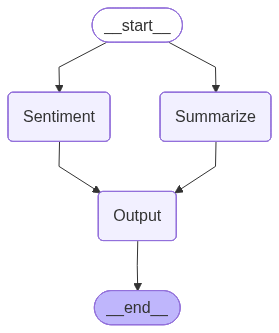

In [67]:
graph = StateGraph(llmstate)

graph.add_node("Summarize", summarize)
graph.add_node("Sentiment", sentiment)
graph.add_node("Output", output)

graph.add_edge(START, "Summarize")
graph.add_edge(START, "Sentiment")
graph.add_edge("Sentiment", "Output")
graph.add_edge("Summarize", "Output")
graph.add_edge("Output" ,END)

workflow = graph.compile()

workflow

In [68]:
query = {"input": "terrorism in india"}

print(workflow.invoke(query)["output"])



{'Sentiment: ': 'negative', 'Summary: ': '**Terrorism in India: A Summary**\n\nTerrorism has been a persistent threat to India\'s national security and stability for decades. The country has faced numerous terrorist attacks, which have resulted in significant loss of life and property. Here\'s a summary of the situation:\n\n**Causes of Terrorism in India:**\n\n1. **Kashmir Dispute**: The Kashmir issue, which is a festering wound between India and Pakistan, has been a major contributor to terrorism in India. Pakistan-backed militant groups have been fueling the insurgency in Jammu and Kashmir, which has led to numerous terrorist attacks.\n2. **Communal Violence**: Communal tensions and sectarian violence have also contributed to terrorism in India. Groups like the Indian Mujahideen (IM) and the Students Islamic Movement of India (SIMI) have been involved in terrorist activities, often targeting civilians and security personnel.\n3. **Left-Wing Extremism**: Left-wing extremist groups, al